<a href="https://colab.research.google.com/github/zslrmhb/Kun_Classifier/blob/main/Kun_Classfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# I uploaded my dataset in google drive in order to train on google colab


Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Kun_Classfier/    

/content/drive/MyDrive/Kun_Classfier


In [ ]:
!ls

'Kun Classfier.ipynb'   只因   坤坤


In [ ]:
!pip install tqdm

import os
import glob
from tqdm import tqdm

import cv2
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss

import torchvision
from torchvision import transforms, models

from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip freeze --local

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.7
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
debugpy==

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Kun_Classfier'

In [ ]:
kun = "坤坤"
chicken = "只因"

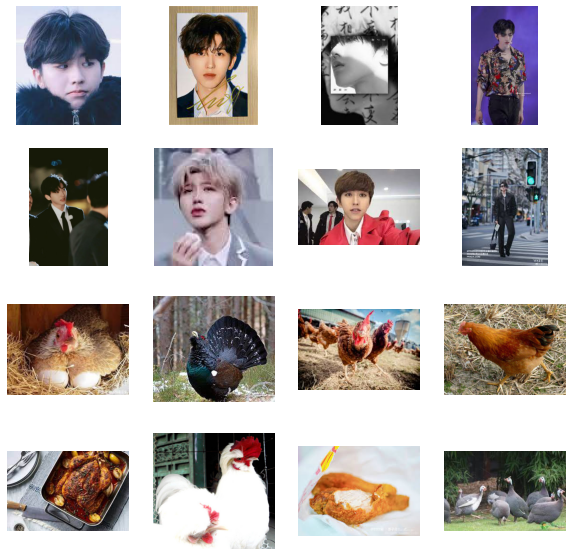

In [ ]:
# let's plot some fun dataset images

kun_dir = os.getcwd() + "/" + kun
chicken_dir = os.getcwd() + "/" + chicken


num_samples = 16
kun_samples  = np.random.choice(glob.glob(kun_dir + "/*"), num_samples)
chicken_samples = np.random.choice(glob.glob(chicken_dir + "/*"), num_samples)

nrows = 4
ncols = 4



fig,ax = plt.subplots(nrows, ncols, figsize=(10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < num_samples / 2:
    pic = plt.imread(kun_samples[i])
    ax[i].imshow(pic)
    ax[i].set_axis_off()

  else:
    pic = plt.imread(chicken_samples[i])
    ax[i].imshow(pic)
    ax[i].set_axis_off()


plt.show()


In [ ]:
class KunDataset(Dataset):
  def __init__(self, transforms=None):
    self.img_path = os.getcwd() + "/"
    self.data = []
    
    self.transforms = transforms

    kun_list = glob.glob(self.img_path + kun)
    chicken_list = glob.glob(self.img_path + chicken)

    print(kun_list[:10])    
    print(chicken_list[:10])

    for class_path in kun_list:
      class_name = kun
      for img_path in glob.glob(class_path + "/*.jpg"):
        self.data.append([img_path, class_name])

    for class_path in chicken_list:
      class_name = chicken
      for img_path in glob.glob(class_path + "/*.jpg"):
        self.data.append([img_path, class_name])

    self.class_map = {"坤坤": 0, "只因": 1}
    self.img_dim = (224, 224)  # we are going to use Resnet-18


  def __len__(self):
    return len(self.data)

    
  def __getitem__(self, idx):
    img_path, class_name = self.data[idx]
    img = Image.open(img_path).convert('RGB') 
    class_id = self.class_map[class_name]             # torchvision transformation only support PIL image
    class_id = torch.tensor([class_id])

    if self.transforms is not None:
      img_tensor = self.transforms(img)
    # else:
    #   resized_img = cv2.resize(img, self.img_dim)
    #   img_tensor = torch.from_numpy(resized_img)
    #   img_tensor = img_tensor.permute(2,0,1)
    return img_tensor, class_id

In [ ]:
transformations = transforms.Compose([transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                    ),                      
])

In [ ]:
dataset = KunDataset(transformations)
num_train = round(0.8 * len(dataset))
num_test = len(dataset) - num_train

train, test = random_split(dataset, [num_train ,num_test]) # split the dataset 80% Train    20% Test

train_data = DataLoader(train, batch_size=16, shuffle=True)
test_data = DataLoader(test, batch_size=16, shuffle=True)

['/content/drive/MyDrive/Kun_Classfier/坤坤']
['/content/drive/MyDrive/Kun_Classfier/只因']


#### The 4 code blocks below are from this post: https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781 with slight modifications


In [ ]:


def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step


In [ ]:
# we will use the pre-trained ResNet-18 and fintune the last layer

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)


#freeze all params (transfer learning)
for params in model.parameters():
  params.required_grad = False

# add a new final layer for binary classification
nr_filters = model.fc.in_features
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# define loss function, optimizer and train_step

#loss
loss_fn = BCEWithLogitsLoss()

#optimizer
optimizer=torch.optim.Adam(model.fc.parameters())

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [ ]:
# Train the model
# %%capture

losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
 
  for i ,data in tqdm(enumerate(train_data), total = len(train_data)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    # y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device).float() #move to gpu

    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(train_data)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in tqdm(test_data):
      x_batch = x_batch.to(device)
      # y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device).float()
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(test_data)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)


100%|██████████| 106/106 [00:12<00:00,  8.75it/s]



Epoch : 1, train loss : 0.07549190521240234


100%|██████████| 27/27 [00:23<00:00,  1.15it/s]

Epoch : 1, val loss : 0.01805218495428562
/nTerminating: early stopping


<All keys matched successfully>

In [ ]:
best_model_wts = model.state_dict()
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [ ]:
PATH = "kun_weight.pt"
torch.save(best_model_wts, os.getcwd() + "/" +PATH)

In [ ]:
def inference(img_path):
  img = Image.open(img_path).convert('RGB') 

  transformations = transforms.Compose([transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                    ),                      
])
  img_tensor = transformations(img).reshape(1,3,224,224).to(device)
  pred = model(img_tensor)
  if torch.sigmoid(pred) < 0.5:
    print("Prediction : 坤坤")
  else:
    print("Prediction : 只因")


# inference("")

Prediction : 坤坤


#### References
1.https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
2.https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

3.https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
4. https://medium.com/analytics-vidhya/dealing-with-pytorch-custom-datasets-64b6c40fe581